<a href="https://colab.research.google.com/github/guilhermecmassaro/MachineLearning_Projects/blob/main/ML_Regression_Logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas

In [14]:

# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Avisos Importantes
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

# Lendo e entendendo a estrutura da base de dados

Essa base de dados contém as seguintes colunas:



*   'Daily Time Spent on Site': tempo do consumidor no site em ** minutos**
*   'Age': idade do consumidor em **anos**
*   'Area Income': Renda **média** da área geográfica do consumidor
*   'Daily Internet Usage': Tempo **médio** em minutos por dia do consumidor na internet
*   'Ad Topic Line': Cabeçalho do anúncio
*   'City': Cidade do consumidor
*   'Gender': Sexo do consumidor
*   'Country': País do consumidor
*   'Timestamp': Horário que o consumidor clicou no anúncio ou fechou a página
*   'Clicked on Ad': 0 - não clicou ou 1 - clicou










In [3]:
df_ads = pd.read_csv('ad_10000records.csv')
df_ads.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


In [5]:
# Podemos perceber que não será necessário realizar nenhuma tratativa em relação aos "missings values" ou valores nulos.
# Será necessário alterar alguns tipos de formato para colunas como Timestamp, por exemplo

df_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked on Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


In [7]:
df_ads.describe().round(2)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad
count,10000.00,10000.00,10000.00,10000.00,10000.00
mean,61.66,35.94,53840.05,177.76,0.49
std,15.70,8.57,13343.71,40.82,0.50
min,32.60,19.00,13996.50,105.22,0.00
25%,48.86,29.00,44052.30,140.15,0.00
50%,59.59,35.00,56180.93,178.92,0.00
75%,76.58,42.00,61840.26,212.67,1.00
max,90.97,60.00,79332.33,269.96,1.00


In [23]:
# Coeficiente de variação
# Gosto de realizar essa conta rapidamente para verificar dentre as colunas aquele que pode estar com os dados mais heterogêneos. Importante caso você vá realizar cálculos estátisticos em cima delas
# Vamos desconsiderar a coluna "Clicked on Ad", pois ela é uma coluna de classificação apenas (varia entre 0 e 1)
print("Coeficiente de variação (desvio padrão/média)\n")

for col in df_ads.columns:
  if (df_ads[col].dtype in [np.float64, np.int64]) and (col != "Clicked on Ad"):
    cv = (df_ads[col].std() / df_ads[col].mean()) * 100
    print(f'{col}: {cv:.2f}%')

Coeficiente de variação (desvio padrão/média)

Daily Time Spent on Site: 25.47%
Age: 23.85%
Area Income: 24.78%
Daily Internet Usage: 22.96%


In [75]:
def create_age_range(x):
  if x <= 10:
    return '0-10'
  elif x <= 20:
    return '11-20'
  elif x <= 30:
    return '21-30'
  elif x <= 40:
    return '31-40'
  elif x <= 50:
    return '41-50'
  elif x <= 60:
    return '51-60'
  elif x <= 70:
    return '61-70'
  else:
    return '71+'



df_ads['Timestamp'] = pd.to_datetime(df_ads['Timestamp'])

df_ads['Day'] = df_ads['Timestamp'].apply(lambda x: x.day)
df_ads['Age Range'] = df_ads['Age'].apply(lambda x: create_age_range(x))
df_ads['Day of Week'] = df_ads['Timestamp'].apply(lambda x: x.weekday()).map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
df_ads['Month'] = df_ads['Timestamp'].apply(lambda x: x.month)
df_ads['Year'] = df_ads['Timestamp'].apply(lambda x: x.year)
df_ads['Hour'] = df_ads['Timestamp'].apply(lambda x: x.hour)

In [76]:
df_ads.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Day,Month,Year,Hour,Day of Week,Age Range
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,9,6,2016,21,Thursday,31-40
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0,16,1,2016,17,Saturday,31-40
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0,29,6,2016,10,Wednesday,21-30
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0,21,6,2016,14,Tuesday,21-30
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1,21,7,2016,10,Thursday,21-30


# EDA (Exploratory Data Analysis) - Geral

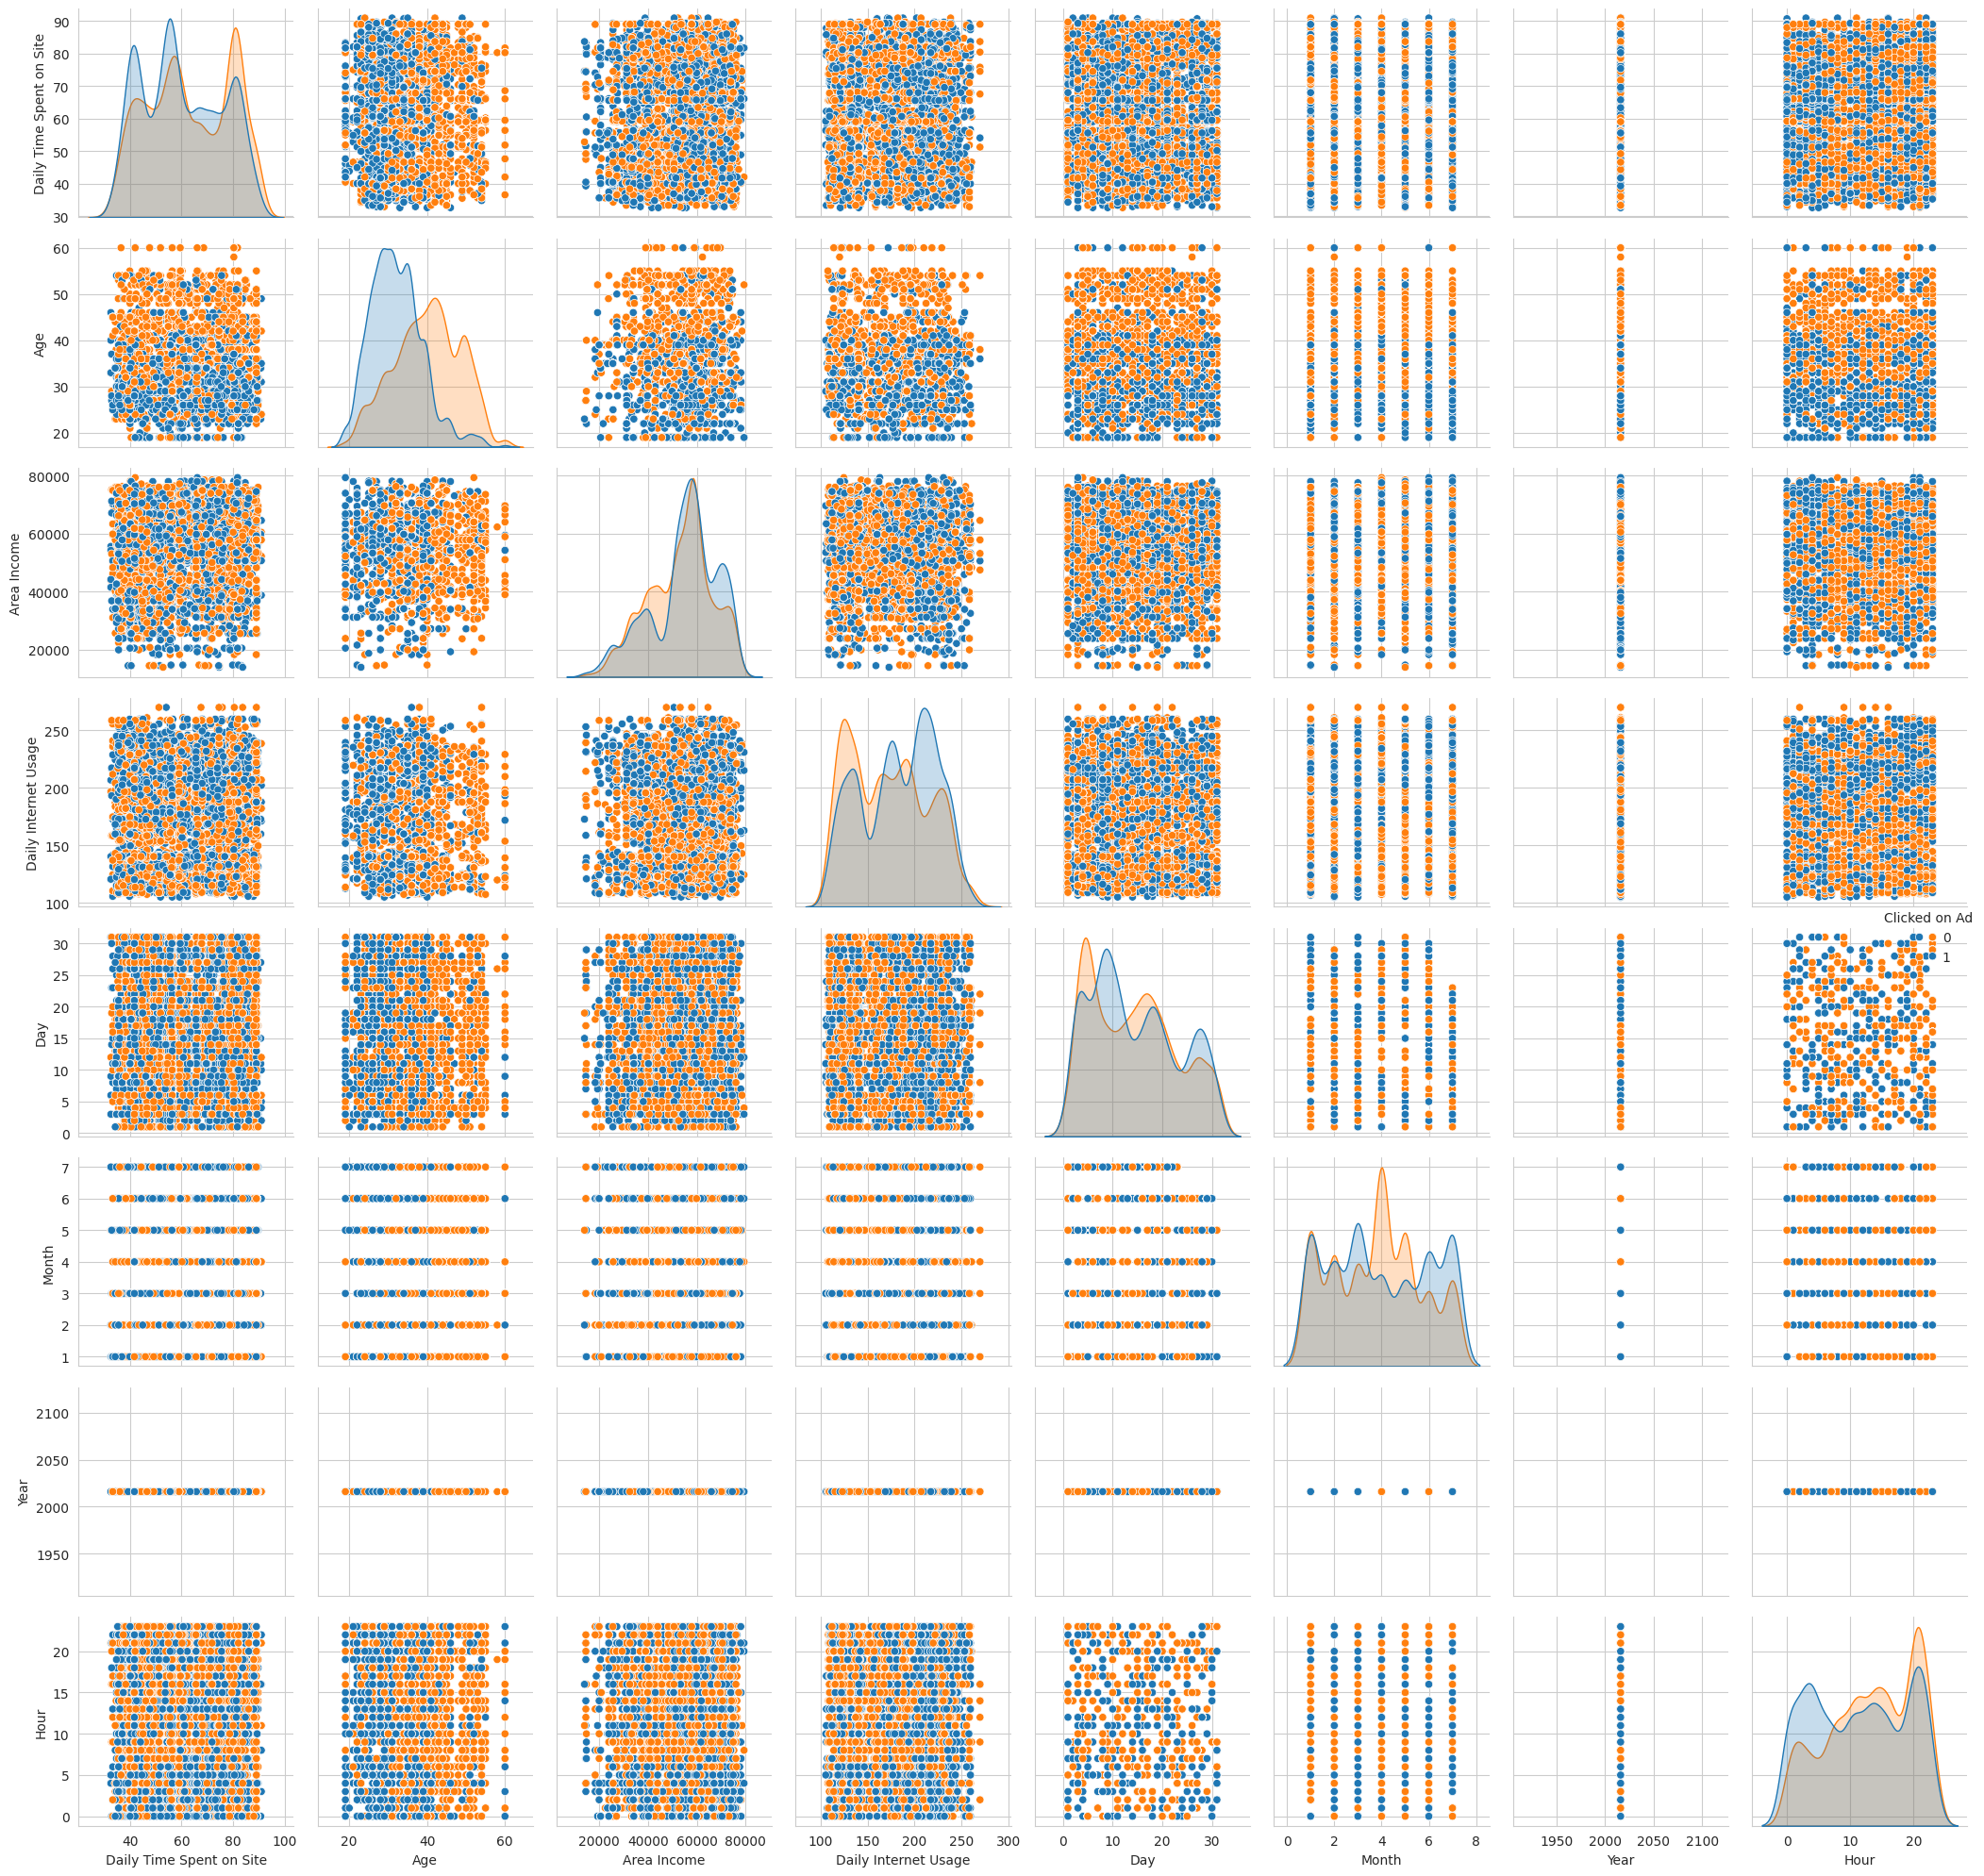

In [37]:
sns.pairplot(data = df_ads, hue = 'Clicked on Ad')
plt.tight_layout()
plt.show()

In [52]:
# Aqui estamos procurando entender a distribuição da base em relação ao gênero das pessoas
# Pode-se observar que possuimos mais pessoas do gêmero feminino do que masculino

gender_distrib = df_ads['Gender'].value_counts(normalize = True).round(2)
gender_distrib

,proportion
Gender,
Female,0.54
Male,0.46


"\n# Gráfico 2\nax2 = axs[1]\nsns.set_style('whitegrid')\nplt.figure(figsize=(12,5))\nage_distr_plot = sns.histplot(ax = ax2,data = df_ads[df_ads['Gender'] == 'Female'], x = 'Age', bins = 40, kde = True, stat= 'density', hue = 'Clicked on Ad')\nax2.set_title('Distribuição de Idade (Mulheres)')\nax2.set_ylabel('')\n"

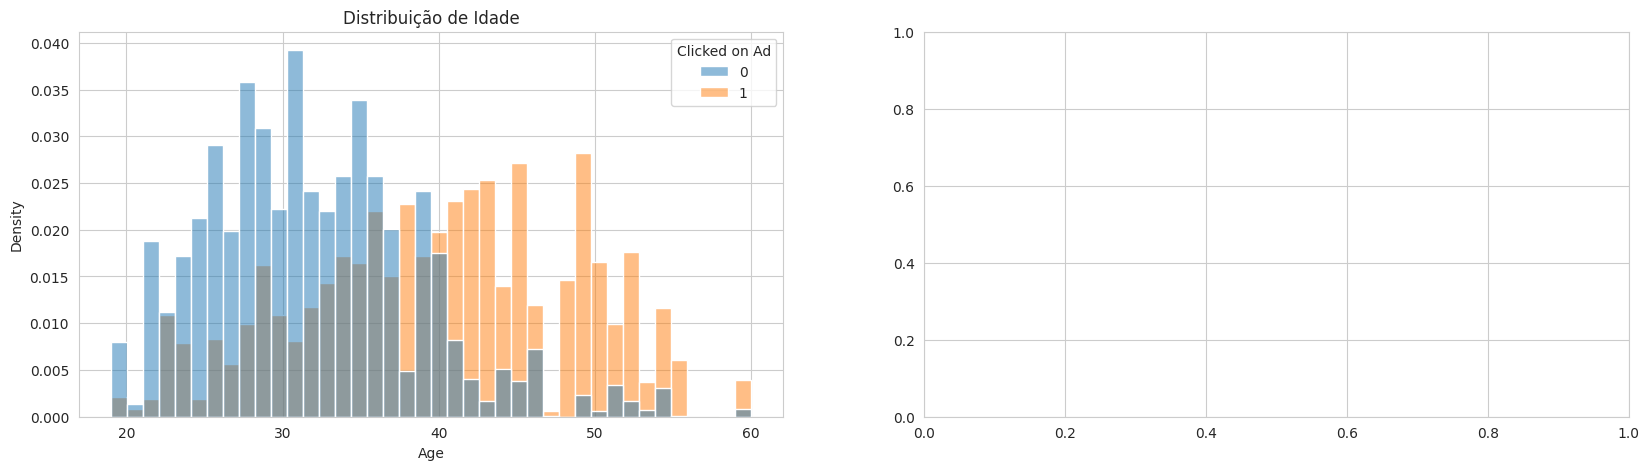

<Figure size 1200x500 with 0 Axes>

In [90]:
# Aqui estamos realizando um histograma de idades para analisar as idades
# A predominância de idades que temos na base está entre 30 a 40 anos
# Há diferenças nas curvas quando olhamos, mas as duas possuem o maior volume de pessoas na mesma faixa etária apontada acima

# Cria uma figura e dois subplots lado a lado
rows, cols = 1,2
fig, axs = plt.subplots(rows, cols, figsize=(20, 5)) # subplots(numero de linhas, numero de colunas, tamanho da figura)


# Gráfico 1
ax1 = axs[0]
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
age_distr_plot = sns.histplot(ax = ax1,data = df_ads, x = 'Age', bins = 40, kde = False, stat= 'density', hue = 'Clicked on Ad')
ax1.set_title('Distribuição de Idade')

""" Colocar gráfico da faixa etária do lado para dar mais força na comparação
# Gráfico 2
ax2 = axs[1]
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
age_distr_plot = sns.histplot(ax = ax2,data = df_ads[df_ads['Gender'] == 'Female'], x = 'Age', bins = 40, kde = True, stat= 'density', hue = 'Clicked on Ad')
ax2.set_title('Distribuição de Idade (Mulheres)')
ax2.set_ylabel('')
"""


# EDA (Exploratory Data Analysis) - Comparando

O objetivo aqui será analisar o comportamento de cada gênero e seus respectivos parâmetros e depois os dois juntos. Estamos levando em consideração se você quisesse realizar um anúncio para segmentando algum público específico, mas no final juntaremos os dois para quem quisesse fazer um anúncio independente do sexo

In [77]:
# Aqui foi separado em grupos de pessoas que clicaram e que não clicaram, vou utilizar apenas as que clicaram
# A ideia de analisar o grupo que não clicou seria mais para entender as piores idades, horários e etc, uma análise mais voltada para o que evitar

df_ads_clicked = df_ads[df_ads['Clicked on Ad'] == 1]
df_ads_not_clicked = df_ads[df_ads['Clicked on Ad'] == 0]

In [82]:
# Como foi visto acima, o gênero feminino é maior tanto na base em geral quanto em relação a cliques

df_ads_clicked['Gender'].value_counts(normalize = True).round(2)

,proportion
Gender,
Female,0.56
Male,0.44


In [83]:
df_ads_clicked_female = df_ads_clicked[df_ads_clicked['Gender'] == 'Female']
df_ads_clicked_male = df_ads_clicked[df_ads_clicked['Gender'] == 'Male']

## Masculino

Text(0, 0.5, 'Faixa etária')

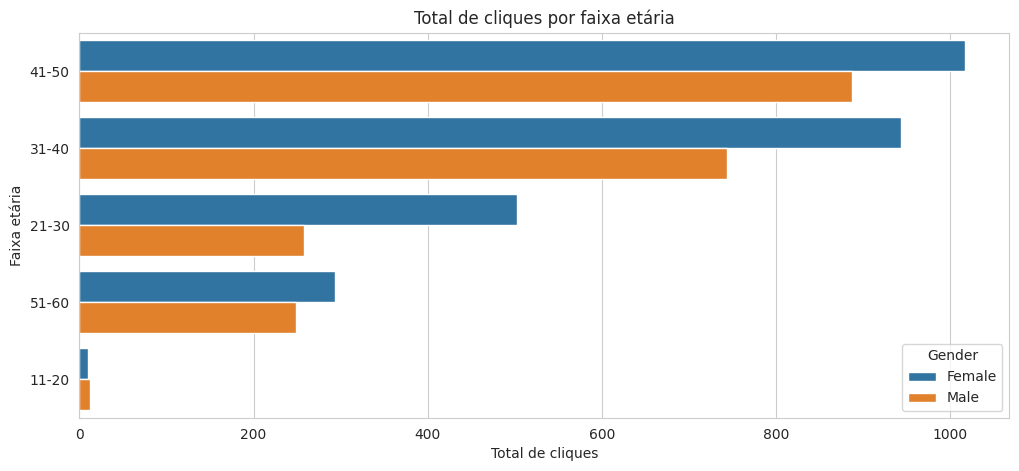

In [103]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
sns.countplot(data = df_ads_clicked, y = 'Age Range', orient = 'h', hue = 'Gender', order= df_ads_clicked['Age Range'].value_counts().index)
plt.title('Total de cliques por faixa etária')
plt.xlabel('Total de cliques')
plt.ylabel('Faixa etária')

Text(2.9372500000000006, 0.5, 'Total de cliques')

<Figure size 1200x500 with 0 Axes>

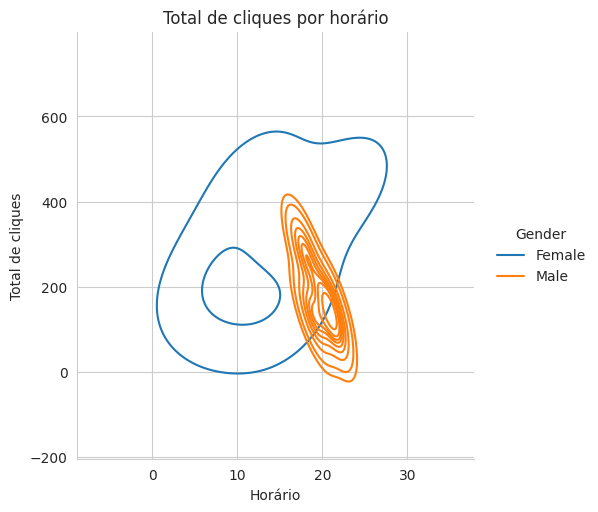

In [109]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
sns.displot(data = df_ads_clicked, hue = 'Gender', x = 'Hour', kind = 'kde',multiple = 'fill',y = df_ads_clicked['Hour'].value_counts())
plt.title('Total de cliques por horário')
plt.xlabel('Horário')
plt.ylabel('Total de cliques')

## Feminino

## Correlações

In [68]:
# Em algumas pesquisas que realizei, encontrei estes valores que são legais para nos apoiar no quão forte ou fraca seria a nossa correlação

data = {'Correlation Strength': ['Very Strong', 'Strong', 'Moderate', 'Weak', 'Very Weak'],
        'Correlation Coefficient (r)': ['0.8 to 1.0 or -0.8 to -1.0', '0.6 to 0.79 or -0.6 to -0.79', '0.4 to 0.59 or -0.4 to -0.59', '0.2 to 0.39 or -0.2 to -0.39', '0 to 0.19 or 0 to -0.19']}

df_corr_numbers = pd.DataFrame(data)
df_corr_numbers

,Correlation Strength,Correlation Coefficient (r)
0,Very Strong,0.8 to 1.0 or -0.8 to -1.0
1,Strong,0.6 to 0.79 or -0.6 to -0.79
2,Moderate,0.4 to 0.59 or -0.4 to -0.59
3,Weak,0.2 to 0.39 or -0.2 to -0.39
4,Very Weak,0 to 0.19 or 0 to -0.19


In [64]:
# Como estamos analisando apenas o ano de 2016, essa coluna será retirada

df_ads_pre_corr = df_ads.drop('Year', axis = 1)
df_ads_corr = df_ads_pre_corr.corr(numeric_only = True)
df_ads_corr

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad,Day,Month,Hour
Daily Time Spent on Site,1.000000,0.100129,0.016288,-0.058930,0.091034,-0.011805,0.006643,0.015781
Age,0.100129,1.000000,-0.051198,-0.106603,0.460383,-0.016857,-0.018134,0.089600
Area Income,0.016288,-0.051198,1.000000,0.041495,-0.067631,0.005539,0.006062,0.054176
Daily Internet Usage,-0.058930,-0.106603,0.041495,1.000000,-0.129412,0.020304,0.023890,-0.026687
Clicked on Ad,0.091034,0.460383,-0.067631,-0.129412,1.000000,-0.014313,-0.044869,0.135601
Day,-0.011805,-0.016857,0.005539,0.020304,-0.014313,1.000000,-0.052869,0.019410
Month,0.006643,-0.018134,0.006062,0.023890,-0.044869,-0.052869,1.000000,-0.115381
Hour,0.015781,0.089600,0.054176,-0.026687,0.135601,0.019410,-0.115381,1.000000


<Axes: >

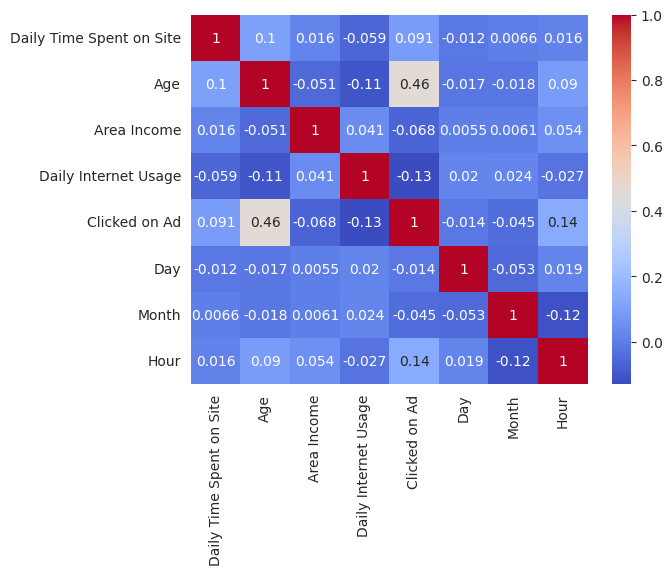

In [65]:
# Pode-se verificar que não temos fortes correlações entre as variáveis desta fonte de dados
# A mais relevante seria entre "Clicked on Ad" e "Age", mas baseada na tabela acima, ela seria considerada moderada

heat_map_corr = sns.heatmap(df_ads_corr, annot = True, cmap = 'coolwarm')
heat_map_corr